In [2]:
from bin.peripheral import peripheral
import polars as pl 
from glob import glob

def get_paths():

    """
    ## type_id correspondance : 

    #   1 : Multitopic transmembrane
    #   2 : Monotopic / Peripherals
    #   3 : Peptides 

    ## classtype_id correspondance :

    ###### Multitopic transmembrane ######
    #  1  : Alpha-helical polytopic 
    #  11 : Bitopic proteins 
    #  2  : Beta barrel 

    ###### Monotopic ######
    #  4  : All alpha 
    #  3  : All beta
    #  5  : Alpha / beta
    #  6  : Alpha + beta

    ###### Peptides #######
    #  7  : Alpha-helical peptides
    #  8  : Beta-helical peptides
    #  9  : Beta hairpins 
    #  10 : Non-regular peptides
    """

    metadata = (

        pl.read_csv("input/proteins-2024-05-07.csv", separator = ",", infer_schema_length = 20000)
            .with_columns(
                pl.concat_str([
                        pl.lit("input/OPM"),
                        pl.concat_str([pl.col("pdbid"), pl.lit(".pdb")], separator = "")           
                    ], separator = "/",
                ).alias("pdb_path")
            )
    )

    ## FILTERS ## 

    # Annotated bitopic proteins, put threshold of 20 to avoid some false positives
    bitopic_proteins = ((pl.col("classtype_id") == 11) & (pl.col("thickness") >= 20)) 
    # All peptides that are crossing the membrane ( > 20 ), regardless of their folding type
    bitopic_peptides = ((pl.col("type_id") == 3) & (pl.col("thickness") >= 20)) 
    # Multitopic proteins to be cut 
    polytopic_proteins = (pl.col("classtype_id") == 1) & (pl.col("thickness") >= 20)
    # Some "peripheral" proteins are anchored to the mb through lipidation, empirical threshold of 12 to remove them
    peripheral_proteins = (pl.col("type_id") == 2) & (pl.col("thickness") <= 12) 
    # All peptides that are not beta-helical or non-regular and that are not crossing the membrane
    peripheral_peptides = ((pl.col("type_id") == 3) & (pl.col("thickness") < 20) & (pl.col("tilt") <= 80)) 
    horizontal_peripheral_peptides = ((pl.col("type_id") == 3) & (pl.col("thickness") < 20) & (pl.col("tilt") > 80))
    # Mis-annotated bitopic proteins
    misannotated_proteins = ((pl.col("classtype_id") == 11) & (pl.col("thickness") < 20))

    membranome = list(glob("input/membranome/*.pdb"))
    bitopic_proteins = metadata.filter(bitopic_proteins)["pdb_path"].to_list()
    bitopic_peptides = metadata.filter(bitopic_peptides)["pdb_path"].to_list()

    tm_paths = {
        
        "bitopic" : bitopic_proteins + bitopic_peptides + membranome,
        "polytopic" : metadata.filter(polytopic_proteins)["pdb_path"].to_list()

    }

    peripheral_proteins = metadata.filter(peripheral_proteins)["pdb_path"].to_list()
    peripheral_peptides = metadata.filter(peripheral_peptides)["pdb_path"].to_list()
    misannotated_proteins = metadata.filter(misannotated_proteins)["pdb_path"].to_list()

    peripheral_paths = {

        "peripheral" : peripheral_proteins + peripheral_peptides + misannotated_proteins,
        "horizontal" : metadata.filter(horizontal_peripheral_peptides)["pdb_path"].to_list(),

    }

    return tm_paths, peripheral_paths




In [1]:
from bin.transmembrane import transmembrane 
from tqdm import tqdm
from glob import glob 
import random

c = 0
for path in tqdm(tm["polytopic"]):

    try:
        
        transmembrane(path, None, 15, 0, 20, 70, 1, None, "input/iORFs.csv", verbose = True)
    except Exception as e:
        c += 1

print(f"Total : {len(tm["polytopic"])}")
print(f"Bad : {c}")


NameError: name 'tm' is not defined

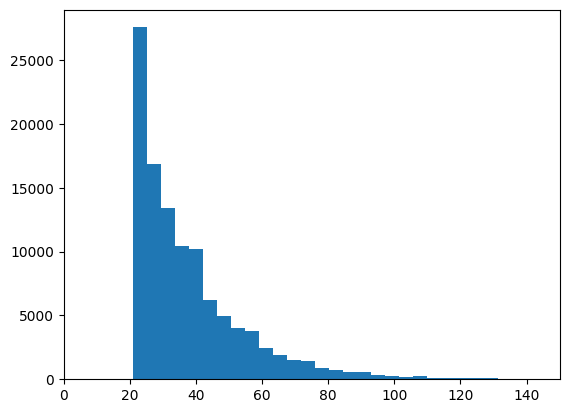